# Model Training Step (Etapa do Treinamento do Modelo)
## Table of Contents
* [Packages](#1)
* [Utils Functions](#2)
    * [Model Functions](#2.1)
        * [$L_2$ Norm Layer](#2.1.1)
        * [User Neural Network](#2.1.2)
        * [Item Neural Network](#2.1.3)
        * [Model Compile](#2.1.4)
        * [Hyperparameter Tuning](#2.1.5)
    * [Plot Function](#2.2)
        * [Plot History](#2.2.1)
* [Model](#3)
    * [Content-Based Filtering Algorithm](#3.1)
* [Hyperparameter Tuning](#4)
* [Content-Based Filtering Model](#5)
* [Model Explanation](#6)
* [Save Weights](#7)

<a class="anchor" id="1"></a>
## Packages (Pacotes)
**[EN-US]**

Packages used in the system.
* [pandas](https://pandas.pydata.org/): is the main package for data manipulation;
* [numpy](www.numpy.org): is the main package for scientific computing;
* [tensorflow](https://www.tensorflow.org/): framework that makes it easy to create ML models that can run in any environment;
* [scikit-learn](https://scikit-learn.org/stable/): open source machine learning library;
* [skopt](https://scikit-optimize.github.io/stable/): is a simple and efficient library to minimize (very) expensive and noisy functions;
* [shap](https://shap.readthedocs.io/en/latest/index.html): is a game theoretic approach to explain the output of any machine learning model;
* [matplotlib](http://matplotlib.org): is a library to plot graphs;
* [warnings](https://docs.python.org/pt-br/3/library/warnings.html): controls whether warnings are ignored, displayed, or turned into errors (raising an exception).

**[PT-BR]**

Pacotes utilizados no sistema.
* [pandas](https://pandas.pydata.org/): é o principal pacote para manipulação de dados;
* [numpy](www.numpy.org): é o principal pacote para computação científica;
* [tensorflow](https://www.tensorflow.org/): framework que facilita a criação de modelos de machine learning que podem ser executados em qualquer ambiente;
* [scikit-learn](https://scikit-learn.org/stable/): biblioteca open-source de machine learning;
* [skopt](https://scikit-optimize.github.io/stable/): é uma biblioteca simples e eficiente para minimizar funções (muito) caras computacionalmente e ruidosas;
* [shap](https://shap.readthedocs.io/en/latest/index.html): é uma abordagem teórica para explicar o output de qualquer modelo de aprendizado de máquina;
* [matplotlib](http://matplotlib.org): é uma biblioteca para plotar gráficos;
* [warnings](https://docs.python.org/pt-br/3/library/warnings.html): controla se os avisos são ignorados, exibidos ou transformados em erros (gerando uma exceção).

In [76]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dot, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.backend import clear_session
from skopt import gp_minimize
import shap

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15) # set default size of plots (definindo o tamanho padrão dos plots)

from warnings import simplefilter
simplefilter('ignore')

Checking tensorflow version (Verificando a versão do tensorflow).

In [22]:
tf.__version__

'2.18.0'

<a name="2"></a>
## Utils Functions (Funções Utilitárias)
**[EN-US]**

Various useful functions used in this system.

**[PT-BR]**

Várias funções utilitárias utilizadas nesse sistema.

<a name="2.1"></a>
### Model Functions (Funções do Modelo)
**[EN-US]**

Utility functions for creating neural networks, defining and defining error metrics, optimizing and evaluating the model. The `user_nn` function creates the user neural network, the `item_nn` function creates the item neural network, and the `compile_model` function compiles and defines the complete model, computing the dot product between the user and item neural networks.

**[PT-BR]**

Funções utilitárias para a criação das redes neurais, definição e definição das métricas de erro, otimização e avaliação do modelo. A função `user_nn` cria a rede neural do usuário, a função `item_nn` cria a rede neural do item, e a função `compile_model` compila e define o modelo completo, computando o dot product entre a rede neural do usuário e do item.

<a name="2.1.1"></a>
#### $L_2$ Norm Layer (Layer da Norma $L_2$)
**[EN-US]**

Creates the `tf.keras.Layer` object that transforms the calculation of the $L_2$ norm into a layer for us to add to the model.

**[PT-BR]**

Cria o objeto `tf.keras.Layer` que transforma o cálculo da norma $L_2$ em uma layer para adicionarmos ao modelo.

In [27]:
class L2_Norm(tf.keras.Layer):
    """
    [EN-US]
    Transforms the L2 norm computation into a layer.

    [PT-BR]
    Transforma o cálculo da norma L2 em uma layer.
    """
    def call(self, X):
        """
        [EN-US]
        Computes the L2 norm in the matrix.
    
        [PT-BR]
        Calcula a norma L2 na matriz X.
        
        Argument:
            X -- X matrix (Matriz X).
        
        Return:
            tf.linalg.l2_normalize -- The L2 norm that will be calculated in the layer.
                                      (A nroma L2 que será calculada na layer.)
        """
        # Returning the calculation that will be performed (Retornando o cálculo que será realizado).
        return tf.linalg.l2_normalize(X, axis=1)

<a name="2.1.2"></a>
#### User Neural Network (Rede Neural do Usuário)
**[EN-US]**

Utility function for creating the user's neural network.

**[PT-BR]**

Função utilitária para a criação da rede neural do usuário.

In [30]:
def user_nn(units=[256, 128, 64], num_outputs=32, lambda_r=1e-3):
    """
    [EN-US]
    Creates the user's neural network.
    
    [PT-BR]
    Cria a rede neural do usuário.
    
    Arguments:
        units -- Vector with the number of neurons in each layer, there are 3 hidden dense layers in total
                 (Vetor com a quantidade de neurônios em cada layers, são 3 camadas densas ocultas no total).
        num_outputs -- Number of units in the output layer (Número de neurônios da output layer).
        lambda_r -- Value of the layer regularization hyperparameter, lambda
                    (Valor do hiperparâmetro de regularização da layer, lambda).

    Return:
        user_NN -- User neural network (Rede neural do usuário).
    """
    # Defining the user's neural network, with 3 dense hidden layers, and 1 output dense layer. Between them we are calculating the batch norm, with the BatchNormalization() layer
    # Definindo a rede neural do usuário, com 3 dense hidden layers, e 1 output dense layer. Entre elas estamos calculando a batch norm, com a layer BatchNormalization()
    user_NN = Sequential([
        Dense(units=units[0], activation='relu', kernel_regularizer=l2(lambda_r), name='user_l1'),
        BatchNormalization(),
        Dense(units=units[1], activation='relu', kernel_regularizer=l2(lambda_r), name='user_l2'),
        BatchNormalization(),
        Dense(units=units[2], activation='relu', kernel_regularizer=l2(lambda_r), name='user_l3'),
        BatchNormalization(),
        Dense(units=num_outputs, activation='linear', name='user_output')
    ], name='user_NN')
    return user_NN

<a name="2.1.3"></a>
#### Item Neural Network (Rede Neural do Item)
**[EN-US]**

Utility function for creating the item's neural network.

**[PT-BR]**

Função utilitária para a criação da rede neural do item.

In [33]:
def item_nn(units=[256, 128, 64], num_outputs=32, lambda_r=1e-3):
    """
    [EN-US]
    Creates the item's neural network.
    
    [PT-BR]
    Cria a rede neural do item.
    
    Arguments:
        units -- Vector with the number of neurons in each layer, there are 3 hidden dense layers in total
                 (Vetor com a quantidade de neurônios em cada layers, são 3 camadas densas ocultas no total).
        num_outputs -- Number of units in the output layer (Número de neurônios da output layer).
        lambda_r -- Value of the layer regularization hyperparameter, lambda
                    (Valor do hiperparâmetro de regularização da layer, lambda).

    Return:
        item_NN -- Item neural network (Rede neural do item).
    """
    # Defining the item's neural network, with 3 dense hidden layers, and 1 output dense layer. Between them we are calculating the batch norm, with the BatchNormalization() layer
    # Definindo a rede neural do item, com 3 dense hidden layers, e 1 output dense layer. Entre elas estamos calculando a batch norm, com a layer BatchNormalization()
    item_NN = Sequential([
        Dense(units=units[0], activation='relu', kernel_regularizer=l2(lambda_r), name='item_l1'),
        BatchNormalization(),
        Dense(units=units[1], activation='relu', kernel_regularizer=l2(lambda_r), name='item_l2'),
        BatchNormalization(),
        Dense(units=units[2], activation='relu', kernel_regularizer=l2(lambda_r), name='item_l3'),
        BatchNormalization(),
        Dense(units=num_outputs, activation='linear', name='item_output')
    ], name='item_NN')
    return item_NN

<a name="2.1.4"></a>
#### Model Compile (Compilação do Modelo)
**[EN-US]**

Utility function to compile the model, using the cost function and the chosen optimization metric, and using the `AUC_ROC` metric to evaluate the predictions.

**[PT-BR]**

Função utilitária para compilar o modelo, utilizando a função de custo e a métrica de otimização escolhida, e utilizando a métrica `AUC_ROC` para avaliação das previsões.

In [36]:
def model_compile(
    optimizer,
    loss, 
    num_user_features, 
    num_item_features,
    item_similarity=False,
    user_units=[256, 126, 64],
    item_units=[256, 126, 64],
    num_outputs=32,
    lambda_r=1e-3
):
    """
    [EN-US]
    Compiles the model.
    
    [PT-BR]
    Compila o modelo.

    Arguments:
        optimizer -- optimizers metrics (Métrica de otimização).
        loss -- Loss function (Função de perca).
        num_user_features -- Number of features in the user dataset (Número de features do dataset do usuário).
        num_item_features -- Number of features in the item dataset (Número de features do dataset do item).
        item_similarity -- If set to True, it will compile only the item's neural network for similarity calculation, otherwise it will compile the complete network.
                           (Se for definida como True, compilará apenas a rede neural do item para o calculo da similaridade, caso contrário, compilará a rede completa).
        user_units -- Vector with the number of neurons in each layer for the user net, there are 3 hidden dense layers in total
                      (Vetor com a quantidade de neurônios em cada layers para a rede do usuário, são 3 camadas densas ocultas no total).
        item_units -- Vector with the number of neurons in each layer for the item net, there are 3 hidden dense layers in total
                      (Vetor com a quantidade de neurônios em cada layers para a rede do item, são 3 camadas densas ocultas no total).
        num_outputs -- Number of units in the output layer (Número de neurônios da output layer).
        lambda_r -- Value of the layer regularization hyperparameter, lambda
                    (Valor do hiperparâmetro de regularização da layer, lambda).

    Return:
        model -- Compiled model (Modelo compilado).
    """
    # Clearing all internal variables (Limpando todas as variáveis internas)
    clear_session()
    
    # Setting the user and item neural network (Definindo a rede neural do usuário e do item)
    user_NN = user_nn(
        user_units,
        num_outputs,
        lambda_r
    )
    item_NN = item_nn(
        item_units,
        num_outputs,
        lambda_r
    )
    
    # Setting the user network input shape
    # Definindo o input shape da rede do usuário
    input_user = Input(shape=(num_user_features,))
    # The user network will receive the output from the Input layer
    # A rede do usuário receberá o output da Input layer
    vu = user_NN(input_user)
    # The l2 norm layer will receive the output from the user network
    # A layer da norma l2 receberá o output da rede do usuário
    vu = L2_Norm()(vu)

    # Setting the item network input shape
    # Definindo o input shape da rede do item
    input_item = Input(shape=(num_item_features,))
    # The item network will receive the output from the Input layer
    # A rede do item receberá o output da Input layer
    vr = item_NN(input_item)
    # The l2 norm layer will receive the output from the item network
    # A layer da norma l2 receberá o output da rede do item
    vr = L2_Norm()(vr)

    # Computing the dot product between the user vector vu and the item vector vi
    # Calculando o dot product entre o vetor do usuário vu e o vetor de itens vi
    output = Dot(axes=1)([vu, vr])

    # Defining the model depending on the parameter value
    # Definindo o modelo dependendo do valor do parâmetro
    if item_similarity:
        # Model with only the item network (Modelo apenas com a rede do item)
        model = Model(input_item, vr)
    else:
        # Complete model, with user and item network (Modelo completo, com a rede do usuário e do item)
        model = Model([input_user, input_item], output)

    # Setting the optimizer and the loss function for the model
    # Definindo o otimizador e a função de perda para o modelo
    opt = optimizer
    cost = loss
    # Compiling the model (Compilando o modelo)
    model.compile(loss=loss, optimizer=opt, metrics=['auc'])

    return model

<a name="2.1.5"></a>
#### Hyperparameter Tuning (Otimização dos Hiperparâmetros)
**[EN-US]**

Utility function to tunning model hyperparameters.

**[PT-BR]**

Função utilitária para otimizar os hiperparâmetros do modelo.

In [39]:
def hiperparams_tune(hiperparams):
    """
    [EN-US]
    Setting the model for hyperparameter optimization.

    [PT-BR]
    Define o modelo para a otimização dos hiperparâmetros.

    Argument:
        hyperparams -- List of hyperparameter value ranges to be optimized
                       (Lista com as faixas de valores dos hiperparâmetros para serem otimizados).

    Return:
        -acc -- Performance metric times negative (Métrica de avaliação vezes negativo). 
    """
    # Setting the threshold to define the probabilities for the classes
    # Definindo o threshold para definir as probabilidades para as classes
    threshold = .5
    # Setting the hyperparameters
    # Definindo os hiperparâmetros
    LR = hiperparams[0]
    lambda_r = hiperparams[1]
    # Setting the loss and the optimizer
    # Definindo a loss e o otimizador
    OPT = Adam(learning_rate=LR)
    LOSS = MeanSquaredError()

    # Defining the model to perform the optimization
    # Definindo o modelo para performar a otimização
    model = model_compile(OPT, LOSS, num_user_features, num_item_features, lambda_r=lambda_r)
    model.fit([user_opt, X_opt], y_train, epochs=200, verbose=0)

    # Computing prediction and performance
    # Calculando a previsão e o desempenho
    acc = model.predict([user_opt, X_opt], verbose=0)
    acc = np.where(acc >= threshold, 1, 0)
    acc = np.mean(acc == y_train)

    # -acc, because we want the pair of hyperparameters that minimizes the metric
    # -acc, porque queremos o par de hiperparâmetros que minimize a métrica
    return -acc

<a name="2.2"></a>
### Plot Utility Function (Função Utilitário do Gráfico)
**[EN-US]**

Utility function for plot. The `plot_loss` function plots the evaluation metric and the loss during model training.

**[PT-BR]**

Função utilitária para o plot. A função `plot_loss` plota a métrica de avaliação e a loss durante o treinamento do modelo.

<a name="2.2.1"></a>
#### Plot History (Plota o Histórico)
**[EN-US]**

Returns a plot with the metric and loss of the model during the training epochs.

**[PT-BR]**

Retorna um plot com a métrica e o loss do modelo durante as epochs de treinamento.

In [43]:
def plot_history(history):
    """
    [EN-US]
    Plots the history of the model's training loss and metrics by epoch.
    
    [PT-BR]
    Plota o histórico da loss e da métrica do treinamento do model por epoch.

    Argument:
        history -- history returned by model training (histórico retornado pelo treino do modelo).
    """
    # Accessing the vector with the loss history (Acessando o vetor com o histórico da loss)
    loss = history.history['loss']
    # Accessing the vector with the metric history (Acessando o vetor com o histórico da métrica)
    metric = history.history['auc']
    # Selecting the number of epochs (Selecionando a quantidade de epochs)
    epochs = range(len(loss))
    # Defining the list with the values to plot (Definindo a lista com os valores para plotar)
    utils = [loss, 'loss'], [metric, 'auc']
    
    # Defining the figure and creating the plots (Definindo a figura e criando os plots)
    fig, ax = plt.subplots(2, 2, figsize=(12, 6))
    for i in range(2):
        fig.suptitle('Performance per Epoch')
        # Plotting with all epochs (Plotando com todas as epochs)
        ax[i, 0].plot(epochs, utils[i][0], color='g')
        ax[i, 0].set_ylabel(utils[i][1])
        ax[i, 0].set_xlabel('epochs')
    
        # Plotting only the final 25% of the epoch (PLotando apenas os 25% final da epoch) 
        ax[i, 1].plot(epochs, utils[i][0], color='g')
        ax[i, 1].set_xlim(int((len(utils[i][0]) * .75)), len(utils[i][0]))
        ax[i, 1].set_xlabel('epochs')
    plt.show()

<a name="3"></a>
## Model
**[EN-US]**

The model used for the recommendation system was the `Content-Based Filtering` algorithm.

**[EN-US]**

O modelo utilizado para o sistema de recomendação foi o algoritmo `Content-Based Filtering`.

<a name="3.1"></a>
### Content-Based Filtering Algorithm
<img align='center' src='../figures/content-based-filtering.png' style='width:600px;'>

**[EN-US]**

The Content-Based Filtering algorithm is a recommendation algorithm that recommends items to the user based on the user's features and the item's features to find a good match by calculating the feature vectors $\vec{v}_u$ for the user and the feature vectors $\vec{v}_r$ for the items. The feature vectors $x$ for the users and items can have different sizes, but the feature vectors $\vec{v}$ for the users and items must have the same size.
* $v_u^{(j)}$: represents a vector of the user's preferences, calculated from the features $x_u^{(j)}$ for user $j$.
* $v_r^{(i)}$: vector of numbers calculated for the item, from the features $x_r^{(i)}$ for item $i$.

With an appropriate choice of these vectors, we expect the dot product between them to be a good predictor of the rating given by user $j$ for item $i$.
$$v_u^{(j)} . v_r^{(i)}$$

**[PT-BR]**

O algoritmo Content-Based Filtering, é um algoritmo de recomendação, que recomenda itens ao usuário, usando como base as características do usuário e as características dos itens para encontrar uma boa combinação, calculando os vetores $\vec{v}_u$ para o usuário e os vetores $\vec{v}_r$ para os itens. Os vetores de features $x$ para os usuários e para os itens podem ter tamanhos diferentes, mas os vetores $\vec{v}$ para os usuários e para os itens devem ter o mesmo tamanho.
* $v_u^{(j)}$: representa um vetor das preferências do usuário, calculados a partir das features $x_u^{(j)}$ para o usuário $j$.
* $v_r^{(i)}$: vetor de número calculados para o item, a partir das features $x_r^{(i)}$ para o item $i$.

Com uma escolha apropriada desse vetores, esperamos que o dot product entre eles seja uma boa previsão da classificação dada pelo usuário $j$ para item $i$.
$$v_u^{(j)} . v_r^{(i)}$$

Reading pre-processed datasets (Lendo os datasets pré-processados).

In [94]:
item_train_norm = pd.read_csv('../data/preprocessed/item_train_norm.csv')
y_train = pd.read_csv('../data/preprocessed/y_train.csv')
user_train_norm = pd.read_csv('../data/preprocessed/user_train_norm.csv')

item_cv_norm = pd.read_csv('../data/preprocessed/item_cv_norm.csv')
y_cv = pd.read_csv('../data/preprocessed/y_cv.csv')
user_cv_norm = pd.read_csv('../data/preprocessed/user_cv_norm.csv')

Defining the number of features for the user and item neural network (Definindo o número de features para a rede neural do usuário e do item).

In [58]:
num_user_features, num_item_features = user_train_norm.shape[1], item_train_norm.shape[1]
print(f'num_user_features: {num_user_features}\nnum_item_features: {num_item_features}')

num_user_features: 13
num_item_features: 23


<a name="4"></a>
## Hyperparameter Tuning (Otimização dos Hiperparâmetros)
**[EN-US]**

The method used to search for the best hyperparameters for the model was `Bayesian optimization`.

**[PT-BR]**

O método utilizado para a busca dos melhores hiperparâmetros para o modelo foi a otimização bayesiana (`bayesian optimization`).

Computing Bayesian Optimization (Calculando a otimização bayesiana).

In [398]:
# Defining the range for testing each hyperparameter
# Definindo a faixa para teste de cada hiperparâmetro
space = [
    (1e-6, 1e-1, 'log-uniform'), # learning_rate
    (1e-6, 1e-1), # lambda_r
]

# Copying the scaled training items and user matrix to optimize the hyperparameters
# Copiando a matriz de itens e de usuário de treino escaladas para otimizar os hiperparâmetros
X_opt = item_train_norm.copy()
user_opt = user_train_norm.copy()

# Performing Bayesian optimization (Performando a bayesian optimization)
opt = gp_minimize(hiperparams_tune, space, random_state=42, verbose=0, n_calls=25, n_random_starts=10)
# Output with the best combinations of hyperparameters
# Output com as melhores combinações dos hiperparâmetros
print(f'Learning rate: {opt.x[0]}\nLambda: {opt.x[1]}')

Learning rate: 0.00016949768237884747
Lambda: 0.009998391606884474


<a name="5"></a>
## Content-Based Filtering Model
**[EN-US]**

To compute the vector $\vec{v}$ given the vector $x$ we need to create a neural network. For the vector $\vec{v}_u$ we will call it **User Network** and for the vector $\vec{v}_r$ we will call it **Item Network**.
* **`User Network`**: receives as input a vector of features of the user $x_u$ and the output layer is not a layer with a single neuron but rather with more, which ends up generating the output $\vec{v}_u$, which is the vector that describes the user.
* **`Item Network`**: receives as input a vector of features of the item $x_r$ and the output layer is not a layer with a single neuron but rather with more, which ends up generating the output $\vec{v}_r$, which is the vector that describes the item.

The user network and the item network can, hypothetically, have different numbers of hidden layers and neurons per hidden layer, only the output layer should have the same dimension between the 2 vectors. We take the user and item neural networks and join the two and then take the inner product of the outputs of both neural networks.
$$v_u^{(j)} . v_r^{(i)}$$
Cost function to adjust all parameters of the neural networks, applying Frobenius norm regularization to encourage the neural networks to keep their parameter values small:
$$J(W, b) = \frac{1}{m} \sum\limits_{(i j): r(i j)=1}^m (v_u^{(j)} . v_r^{(i)} - y^{(i j)})^2 + \frac{\lambda}{2m} ||W^{[l]}||^2_F$$

**[PT-BR]**

Para computar o vetor $\vec{v}$ dado o vetor $x$ precisamos criar uma rede neural. Para o vetor $\vec{v}_u$ chamaremos de **Rede do Usuário** e para o vetor $\vec{v}_r$ chamaremos de **Rede do Item**.
* **`Rede do Usuário`**: recebe como input um vetor de features do usuário $x_u$ e a output layer não é uma layer com um único neurônio e sim com mais, que acaba gerando o output $\vec{v}_u$, que é o vetor que descreve o usuário.
* **`Rede do Item`**: recebe como input um vetor de features do item $x_r$ e a output layer não é uma layer com um único neurônio e sim com mais, que acaba gerando o output $\vec{v}_r$, que é o vetor que descreve o item.

A user network e a item network, podem, hipoteticamente, ter números diferentes de hidden layers e de neurônios por hidden layers, apenas a output layer deverá ter a mesma dimenção entre os 2 vetores. Pegamos a rede neural de usuários e de itens e juntamos as duas e, em seguida, pegamos o inner product dos outputs de ambas as redes neurais.
$$v_u^{(j)} . v_r^{(i)}$$
Cost function para ajustar todos os parâmetros das redes neurais, aplicando a regularização da norma Frobenius para incentivar as redes neurais a manter os valores de seus parâmetros pequenos:
$$J(W, b) = \frac{1}{m} \sum\limits_{(i j): r(i j)=1}^m (v_u^{(j)} . v_r^{(i)} - y^{(i j)})^2 + \frac{\lambda}{2m} ||W^{[l]}||^2_F$$

Setting the model (Definindo o modelo).

In [403]:
LR = opt.x[0]
LAMBDA = opt.x[1]
OPT = Adam(learning_rate=LR)
LOSS = MeanSquaredError()

model = model_compile(OPT, LOSS, num_user_features, num_item_features, lambda_r=LAMBDA)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_NN             │ (None, 32)        │     47,958 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_NN             │ (None, 32)        │     50,518 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2__norm (L2_Norm)  │ (None, 32)        │          0 │ user_NN[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2__norm_1          │ (None, 32)        │          0 │ item_NN[0][0]     │
│ (L2_Norm)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ l2__norm[0][0],   │
│                     │                   │            │ l2__norm_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,476 (384.67 KB)

 Trainable params: 96,692 (377.70 KB)

 Non-trainable params: 1,784 (6.97 KB)

<a name="6"></a>
## Model Explanation (Explicação do Modelo)
**[EN-US]**

Model explanation with shap value. SHAP (`SHapley Additive exPlanations`) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

**[PT-BR]**

Explicação do modelo com shap value. SHAP (`SHapley Additive exPlanations`) é uma abordagem para explicar o output de qualquer modelo de machine learning. Ela conecta a ótima credit allocation com explicações locais usando os valores clássicos de Shapley e suas extensões relacionadas.

Computing SHAP values (Calculando os SHAP values).

In [594]:
item_model = model_compile(OPT, LOSS, num_user_features, num_item_features, lambda_r=LAMBDA, item_similarity=True)

explainer = shap.Explainer(item_model, item_train_norm)
shap_values = explainer(item_train_norm)

PermutationExplainer explainer: 590it [01:32,  5.72it/s]                         


Ploting SHAP values with beeswarm summary plot (Plotando os SHAP values com o beeswarm summary plot).

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output (O beeswarm plot foi projetado para exibir um resumo denso de informações sobre como as principais features em um dataset impactam o output do modelo).

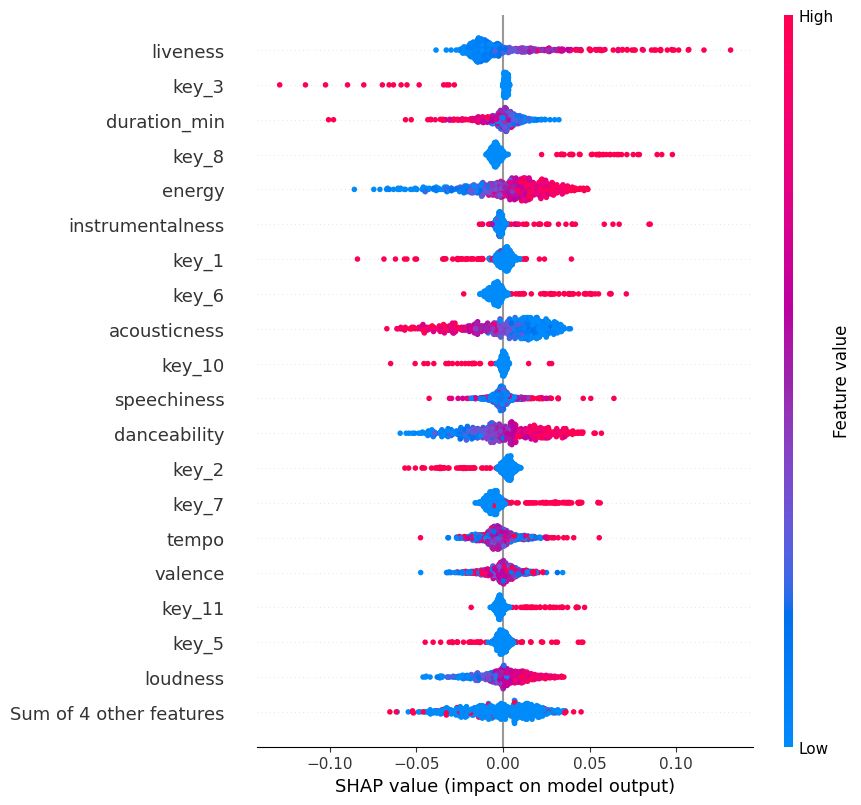

In [686]:
shap.plots.beeswarm(
    shap_values[:, :, 0],
    max_display=20,
    order=shap.Explanation.abs.max(0),
    show=False,
    #color=plt.get_cmap('PuBuGn')
)
# Setting the show parameter to False allows the plot to be customized further after it has been created,
# returning the current axis via matplotlib.pyplot.gca()
# Definir o parâmetro show como False permite que o gráfico seja personalizado ainda mais depois de ter sido criado,
# retornando o eixo atual via matplotlib.pyplot.gca()
ax = plt.gca()
# Selecting the index of each column of the training set of items
# Selecionando o índice de cada coluna do training set dos itens
labels = item_train_norm.columns.tolist()
# Selecting the current labels of each feature on the y-axis
# Selecionando os labels atuais de cada feature no eixo y
tick_labels = ax.get_yticklabels()

for i in range(len(tick_labels)):
    # The first label is the 'Sum of 4 other features
    # So we don't want to update it
    # O primeiro label é a 'Sum of 4 other features
    # Portanto, não queremos atualizá-la
    if i == 0:
        continue
    # Updating the rest of the labels with the corresponding feature label
    # Atualizando o restante dos labels com o label da feature correspondente
    idx = tick_labels[i].get_text().replace('Feature ', '')
    tick_labels[i] = labels[int(idx)]

# Defining new labels for each y-axis feature
# Definindo os novos labels de cada feature do eixo y
ax.set_yticklabels(tick_labels)
plt.show()

Fitting the model (Treinando o modelo).

In [410]:
# Verbose 0 due to the number of epochs (Verbose 0 por conta da quantidade de epochs)
history = model.fit([user_train_norm, item_train_norm], y_train, epochs=300, verbose=0)

Plotting the error and metric during model training (Plotando o erro e a métrica durante o treinamento do modelo).

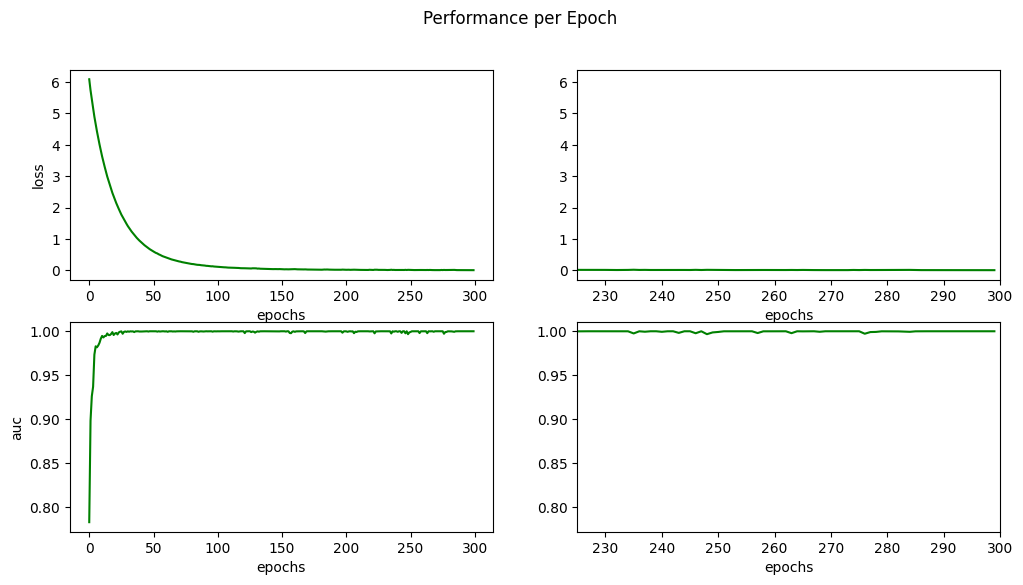

In [412]:
plot_history(history)

Evaluating the model on training and validation data (Avaliando o modelo nos dados de treino e de validação).

In [414]:
train_eval = model.evaluate([user_train_norm, item_train_norm], y_train, verbose=0)
cv_eval = model.evaluate([user_cv_norm, item_cv_norm], y_cv, verbose=0)

print(f'Train set evaluation: {train_eval[0]:.2f}\nValidation set evaluation: {cv_eval[0]:.2f}')

Train set evaluation: 0.01
Validation set evaluation: 0.05


<a name="7"></a>
## Save Weights (Salvar os Pesos)
**[EN-US]**

We will save the pre-trained weights of the model for inference.

**[PT-BR]**

Salvaremos os pesos pré-treinados do modelo para inferência.

Saving the pre-trained weights of the model (Salvando os pesos pré-treinados do modelo).

In [449]:
model.save_weights('../model/pretrained.weights.h5')